In [1]:
import pybamm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Synthetic data generation - experimentation/set-up

### Define PDF

In [2]:
# Define the triangle probability density function for T
def triangle_pdf(I, Imax):
    if I < 0 or I > Imax:
        return 0
    else:
        return (Imax - I) / (Imax ** 2)

Text(0, 0.5, 'f(I)')

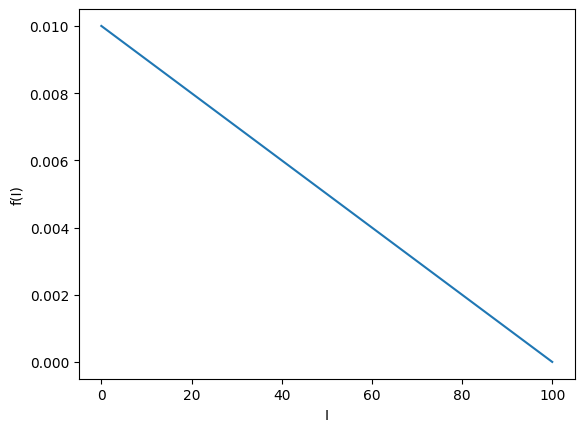

In [3]:
# Sanity check for triangular pdf
x = np.linspace(0,100)
f = lambda z: triangle_pdf(z,100)
v = np.vectorize(f)
y = v(x)
plt.plot(x, y)
plt.xlabel('I')
plt.ylabel('f(I)')

### Custom current function

In [4]:
np.random.seed = 42

In [5]:
# Sample Ij values from the triangle pdf
def sample_Ij(Imax):
    I = np.linspace(0, Imax, 10000)
    return np.random.choice(I, p=[triangle_pdf(x, Imax) for x in I]/sum([triangle_pdf(x, Imax) for x in I]))

In [6]:
# Define custom current function
def custom_current(I_values, M):
    def current(t):
        I_piecewise = 0
        for j in range(M):
            t1, t2 = j * 100, (j + 1) * 100
            I1, I2 = I_values[j], I_values[j + 1]
            I_current_interval = I1 + (I2 - I1) * (t - t1) / (t2 - t1)
        return I_current_interval
    return current

### Model set up

In [7]:
# Set up the PyBaMM simulation
model = pybamm.lithium_ion.SPM()
parameter_values = model.default_parameter_values
Imax = parameter_values["Current function [A]"]

In [8]:
V_min = parameter_values['Lower voltage cut-off [V]']
V_max = parameter_values['Upper voltage cut-off [V]']
print(V_min, V_max)

3.105 4.1


In [9]:
model.events.append(pybamm.Event('Minimum voltage', model.variables['Terminal voltage [V]'] - V_min, pybamm.EventType.TERMINATION))
model.events.append(pybamm.Event('Maximum voltage', V_max - model.variables['Terminal voltage [V]'], pybamm.EventType.TERMINATION))

In [10]:
parameter_values

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.4,
 'Cell cooling surface area [m2]': 0.0569,
 'Cell volume [m3]': 7.8e-06,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 0.680616,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 0.3,
 'Electrode height [m]': 0.137,
 'Electrode width [m]': 0.207,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Capiglia1999 at 0x12da558b0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Capiglia1999 at 0x12da55820>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 19986.609595075,
 'Initial concentration in positive electrode [mol.m-3]': 30730.7554385565,
 'Initial inner SEI thickness [m]': 2.5e-09,
 'Initial outer SEI thickness [m]': 2.5e-09,
 

In [11]:
# How to set initialization as uniform Li-ion concentration in particles and electrolyte?
# initial_soc = 1

# c_n_init = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
# c_p_init = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
# parameter_values["Initial concentration in negative electrode [mol.m-3]"] = c_n_init * initial_soc
# parameter_values["Initial concentration in positive electrode [mol.m-3]"] = c_p_init * initial_soc

In [12]:
Imax

0.680616

In [13]:
M = 15 
t = [100*i for i in range(M + 1)]
I_values = [sample_Ij(Imax) for i in range(M + 1)]

In [14]:
I_values

[0.08508550855085509,
 0.4058238415841584,
 0.26873407020702067,
 0.09148393879387938,
 0.4161021710171017,
 0.6262293429342934,
 0.23347463546354635,
 0.3883302610261026,
 0.032740903690369035,
 0.34578750675067504,
 0.5180005760576057,
 0.47361997479747975,
 0.08304345634563456,
 0.07800639423942395,
 0.16601884428442842,
 0.015451528352835283]

Text(0, 0.5, 'Current (A)')

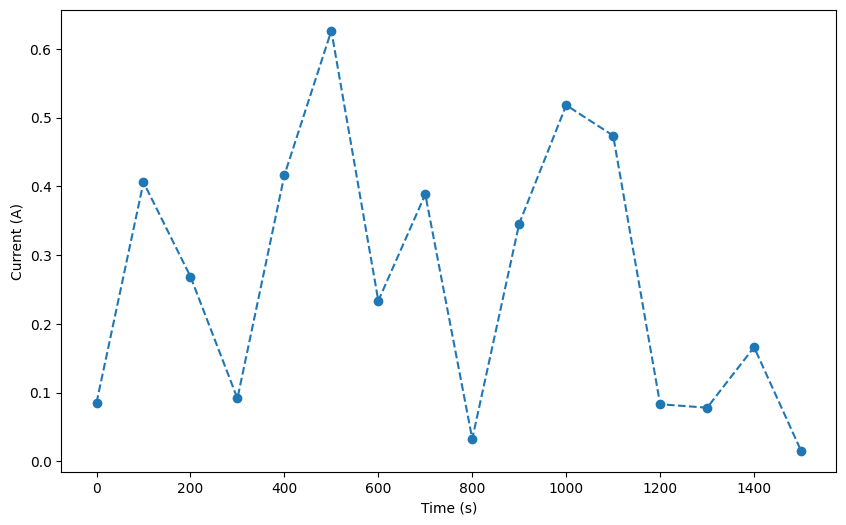

In [15]:
# Plot current function to check
plt.figure(figsize=(10,6))
plt.plot(t, I_values, linestyle='--', marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')

In [16]:
parameter_values["Current function [A]"] = custom_current(I_values, M)

### Run simulation

In [17]:
sim = pybamm.Simulation(model, parameter_values=parameter_values)

In [18]:
sim.model.initial_conditions

{Variable(-0x544716171a6fbfa7, Discharge capacity [A.h], children=[], domains={}): Scalar(0x5d73b3a7dffdff08, 0.0, children=[], domains={}),
 Variable(-0x60fb51dae02eb403, X-averaged negative particle concentration, children=[], domains={'primary': ['negative particle'], 'secondary': ['current collector']}): XAverage(0x6bf83556ec304e8c, x-average, children=['Initial concentration in negative electrode [mol.m-3] / Maximum concentration in negative electrode [mol.m-3]'], domains={'primary': ['negative particle'], 'secondary': ['current collector']}),
 Variable(-0x24b8476c7561d4d3, X-averaged positive particle concentration, children=[], domains={'primary': ['positive particle'], 'secondary': ['current collector']}): XAverage(-0x18509efbde8d580f, x-average, children=['Initial concentration in positive electrode [mol.m-3] / Maximum concentration in positive electrode [mol.m-3]'], domains={'primary': ['positive particle'], 'secondary': ['current collector']})}

In [19]:
t_eval = np.linspace(0, 100 * M, M + 1)
solution = sim.solve(t_eval=t_eval)

In [20]:
t_eval

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500.])

In [21]:
model.variable_names()

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'r_n',
 'r_n [m]',
 'r_p',
 'r_p [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Throughput capacity [A.h]',
 'Porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Separator porosity',
 'X-averaged separator porosity',
 'Positive electrode porosity',
 'X-averaged positive electrode porosity',
 'Porosity change',
 'Negative electrode porosity change',
 'X-averaged negative electrode porosity change',
 'Separator porosity change',
 'X-averaged separator porosity change',
 'Positive electrode porosity change',
 'X-averaged positive electrode porosity change',
 'Negative electrode interface utilisation variable',
 'X-averaged negative electrode interface utilisation variabl

In [22]:
voltage = solution['Terminal voltage [V]']
neg_conc = solution['Negative particle concentration']
pos_conc = solution['Positive particle concentration']

final_time_idx = -1
neg_conc_final = neg_conc.entries[:, final_time_idx]
pos_conc_final = neg_conc.entries[:, final_time_idx]

#neg_conc_units = solution['Negative particle concentration [mol.m-3]']
#pos_conc_units = solution['Positive particle concentration [mol.m-3]']

In [23]:
solution["Time [s]"].entries

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000., 1100., 1200., 1300., 1400., 1500.])

### Visualize

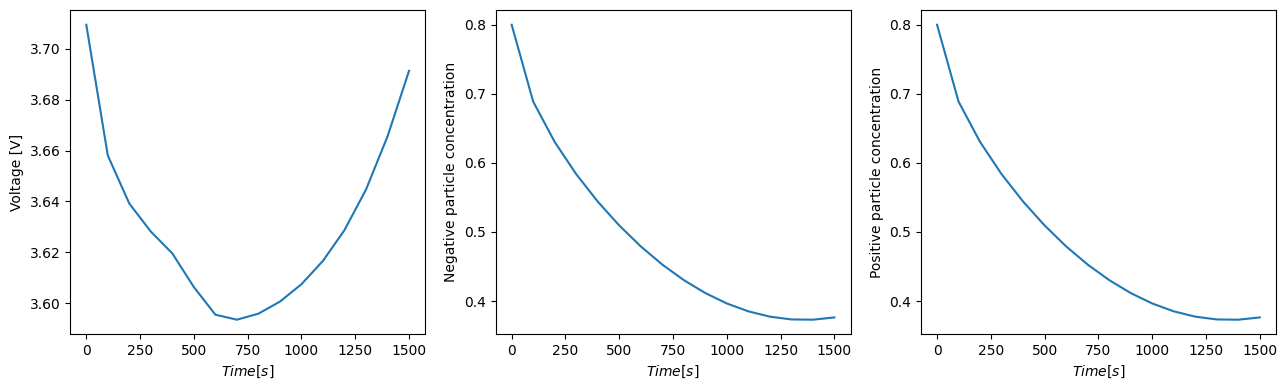

In [24]:
t = solution["Time [s]"].entries
x = solution["x [m]"].entries[:, 0]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))

ax1.plot(t, voltage(t))
ax1.set_xlabel(r'$Time [s]$')
ax1.set_ylabel('Voltage [V]')

ax2.plot(t, neg_conc_final[-1])  # change index to change
ax2.set_xlabel(r'$Time [s]$')
ax2.set_ylabel('Negative particle concentration')

ax3.plot(t, pos_conc_final[-1])  # change index to change x
ax3.set_xlabel(r'$Time [s]$')
ax3.set_ylabel('Positive particle concentration')

plt.tight_layout()
plt.show()

In [25]:
termination_reason = solution.termination

if termination_reason == 'event: Minimum voltage' or termination_reason == 'event: Maximum voltage':
    print("Battery failed during time window __")
else:
    print("Battery did not fail during time window __")

Battery did not fail during time window __


In [26]:
solution.termination

'final time'

Questions:

- SPM or SPMe? SPM is good. 
- What value of Imax to use? Currently set it to value in Current function [A]. That's fine.
- Check on battery failure set-up. Is this the way to do it?
    - How to model the depletion / failure part?
- Do we need to set the initial conditions as outlined in the code?
- Output: surface concentration vs concentration?
- Keras or pytorch?

# Generate training data

- 15,000 use cycles
- M = 15 => each use cycle is 1500 seconds
- There are only 165 use cycles in the data set that do not deplete the battery

In [27]:
n_cycles = 15000
M = 15

In [28]:
# Define the triangle probability density function for T
def triangle_pdf(I, Imax):
    if I < 0 or I > Imax:
        return 0
    else:
        return (Imax - I) / (Imax ** 2)

In [29]:
# Sample Ij values from the triangle pdf
def sample_Ij(Imax):
    I = np.linspace(0, Imax, 10000)
    return np.random.choice(I, p=[triangle_pdf(x, Imax) for x in I]/sum([triangle_pdf(x, Imax) for x in I]))

In [30]:
# Define custom current function
def custom_current(I_values, M):
    def current(t):
        I_piecewise = 0
        for j in range(M):
            t1, t2 = j * 100, (j + 1) * 100
            I1, I2 = I_values[j], I_values[j + 1]
            I_current_interval = I1 + (I2 - I1) * (t - t1) / (t2 - t1)
        return I_current_interval
    return current

In [31]:
def compute_initial_voltage(model, parameter_values):
    sim_temp = pybamm.Simulation(model, parameter_values=parameter_values)
    t_eval = np.array([0, 1e-6])
    solution_temp = sim_temp.solve(t_eval)
    return solution_temp['Terminal voltage [V]'](0)

In [32]:
def simulate_cycle(M=15):
    # set up model
    model = pybamm.lithium_ion.SPM()
    parameter_values = model.default_parameter_values
    Imax = parameter_values["Current function [A]"]
    # set up failure event
    V_min = parameter_values['Lower voltage cut-off [V]']
    V_max = parameter_values['Upper voltage cut-off [V]']
    model.events.append(pybamm.Event('Minimum voltage', 
                                     model.variables['Terminal voltage [V]'] - V_min, pybamm.EventType.TERMINATION))
    model.events.append(pybamm.Event('Maximum voltage', 
                                     V_max - model.variables['Terminal voltage [V]'], pybamm.EventType.TERMINATION))   
    
    # set up and run simulation
    t_eval = np.linspace(0, 100 * M, (M + 1))
    
    # custom current with check for valid initial voltage
    valid_current = False
    while not valid_current:
        I_values = [sample_Ij(Imax) for i in range(M + 1)]
        parameter_values["Current function [A]"] = custom_current(I_values, M)
        try:
            initial_voltage = compute_initial_voltage(model, parameter_values)
            if V_min < initial_voltage < V_max:
                valid_current = True
        except:
            print("""SolverError: Events ['Maximum voltage', 'Maximum voltage'] are 
                  non-positive at initial conditions""")
            continue
    
    #I_values = [sample_Ij(Imax) for i in range(M + 1)]
    #parameter_values["Current function [A]"] = custom_current(I_values, M)
    
    sim = pybamm.Simulation(model, parameter_values=parameter_values)
    
    solution = sim.solve(t_eval=t_eval)
    
    voltage = solution['Terminal voltage [V]']
    neg_conc = solution['Negative particle concentration']
    pos_conc = solution['Positive particle concentration']

    final_time_idx = -1
    neg_conc_final = neg_conc.entries[:, final_time_idx]
    pos_conc_final = neg_conc.entries[:, final_time_idx]
    
    sol_time = solution["Time [s]"]
    
    failure = False
    termination_reason = solution.termination
    if termination_reason == 'event: Minimum voltage' or termination_reason == 'event: Maximum voltage':
        failure = True
    
    return voltage, neg_conc, pos_conc, sol_time, failure, termination_reason

In [33]:
def generate_training_data(n_cycles, M=15):
    voltage = []
    neg_conc = []
    pos_conc = []
    solution_time = []
    failure = []
    termination_reason = []
    for i in range(n_cycles):
        print("starting simulation:", i)
        v, n, p, st, f, t = simulate_cycle(M)
        voltage.append(v.entries)
        neg_conc.append(n.entries)
        pos_conc.append(p.entries)
        solution_time.append(st.entries[-1])
        failure.append(f)
        termination_reason.append(t)
    
    return voltage, neg_conc, pos_conc, solution_time, failure, termination_reason

In [34]:
def process_training_data(voltage, neg_conc, pos_conc, solution_time, failure, termination_reason):
    for i in range(len(failure)):
        if failure[i]:
            size = len(voltage[i])
            diff = 16 - size
            voltage_padded = np.pad(voltage[i], (0, diff), 'constant')
            neg_conc_padded = np.pad(neg_conc[i], [(0, 0), (0, 0), (0, diff)], 'constant')
            pos_conc_padded = np.pad(pos_conc[i], [(0, 0), (0, 0), (0, diff)], 'constant')
            voltage[i] = voltage_padded
            neg_conc[i] = neg_conc_padded
            pos_conc[i] = pos_conc_padded
    return voltage, neg_conc, pos_conc, solution_time, failure, termination_reason

In [35]:
from tempfile import TemporaryFile

def save_to_disk(voltage, neg_conc, pos_conc, solution_time, failure, termination_reason, name="batch0"):
    metadata = pd.DataFrame({'solution_time': solution_time, 
                             'failure': failure, 
                             'termination_reason': termination_reason})
    metadata.to_csv(name + ".csv")
    
    outfile = TemporaryFile()
    np.savez(name + "np", voltage=voltage, neg_conc=neg_conc, pos_conc=pos_conc)

In [46]:
voltage, neg_conc, pos_conc, solution_time, failure, termination_reason = generate_training_data(5, 15)

In [44]:
voltage_p, neg_conc_p, pos_conc_p, solution_time_p, failure_p, termination_reason_p = process_training_data(voltage,
                                                                                               neg_conc,
                                                                                               pos_conc,
                                                                                               solution_time,
                                                                                               failure,
                                                                                               termination_reason)

In [45]:
save_to_disk(voltage_p, neg_conc_p, pos_conc_p, solution_time_p, failure_p, termination_reason_p, name="batch0")

In [42]:
# run the script to generate data for 15000 use cycles in batches of 1000
for i in range(15):
    print("BATCH #" + str(i))
    voltage, neg_conc, pos_conc, solution_time, failure, termination_reason = generate_training_data(1000, 15)
    voltage_p, neg_conc_p, pos_conc_p, solution_time_p, failure_p, termination_reason_p = process_training_data(
        voltage,
        neg_conc,
        pos_conc,
        solution_time,
        failure,
        termination_reason)
    
    save_to_disk(voltage_p, 
                 neg_conc_p, 
                 pos_conc_p, 
                 solution_time_p, 
                 failure_p, 
                 termination_reason_p, 
                 name="batch" + str(i))

# Check training data

In [68]:
def check_failure():
    times = []
    num_failure = 0
    for i in range(15):
        df = pd.read_csv(f"batch{i}.csv")
        num_failure = num_failure + (1000 - df['failure'].sum())
        times.append(df["solution_time"].tolist())
    return num_failure, times

In [69]:
num_failure, times = check_failure()

In [72]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [73]:
cycle_times = flatten(times)

<AxesSubplot:ylabel='Count'>

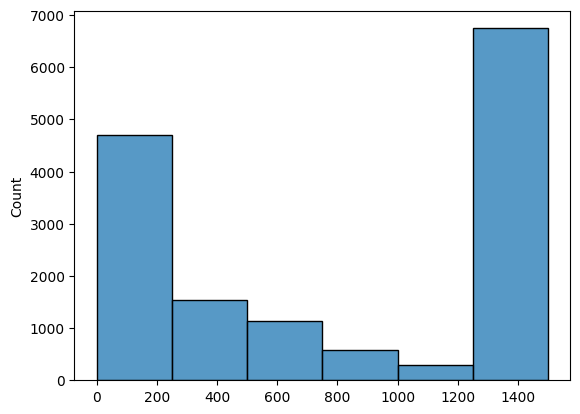

In [78]:
import seaborn as sns

sns.histplot(data=cycle_times, bins=6)

Data distribution is totally off...need to fix and re-simulate